In [1]:
import re

import pandas as pd
import spacy
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm
from sklearn.base import TransformerMixin

In [2]:
spacy_model =  spacy.load('ru_core_news_sm')

In [3]:
tqdm.pandas()

In [4]:
XTRAIN_PATH = "data/train.csv"
XTEST_PATH = "data/test.csv"

RANDOM_STATE = 42

# Анализ датасета

In [5]:
X = pd.read_csv(XTRAIN_PATH)
X.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


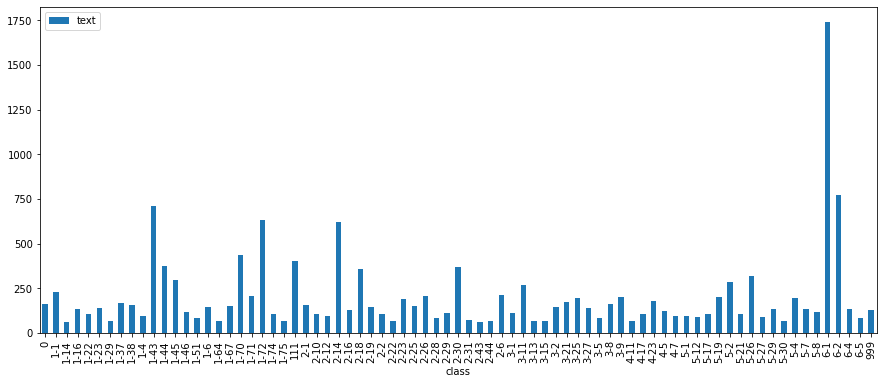

In [6]:
X.groupby('class').count().plot(kind='bar', figsize=(15, 6));

In [7]:
X.groupby('class').count().describe()

,text
count,77.000000
mean,200.636364
std,229.875304
min,64.000000
25%,95.000000
50%,136.000000
75%,202.000000
max,1738.000000


In [8]:
X.shape

(15449, 2)

In [9]:
X['class'].nunique()

77

В исходном датасете 15449 строк. Запросы разделены на 77 категорий. В среднем на каждую категрию приходится 230 запросов. Датасет несбалансирован, самая крупная категория - "6-1", в ней 1738 запросов, в то время как минимальное число запросов в категории - 64. Названия категорий начинаются с цифр 1-6 или 9, что может указывать на более общую группу запросов, а вторая половина названия похожа на уточнение, то есть на более узкую группу запросов.

# Предобработка текста

In [10]:
X['spacy'] = X['text'].progress_apply(spacy_model)

100%|██████████| 15449/15449 [06:49<00:00, 37.70it/s]


In [11]:
X['lemmatized'] = X['spacy'].progress_apply(
    lambda text: ' '.join([word.lemma_ for word in text if word.pos_ not in ['PUNCT', 'SYM', 'NUM', 'PROPN']])
)
X['lemmatized'] = X['lemmatized'].progress_apply(lambda text : re.sub('(\d+ )', '', text))

100%|██████████| 15449/15449 [00:00<00:00, 94196.82it/s]


In [12]:
stemmer = SnowballStemmer(language='russian')
X['stemmed'] = X['spacy'].progress_apply(
    lambda text: ' '.join([stemmer.stem(word.lemma_) for word in text if word.pos_ not in ['PUNCT', 'SYM', 'NUM', 'PROPN']])
)
X['stemmed'] = X['stemmed'].progress_apply(lambda text : re.sub('(\d+ )', '', text))

100%|██████████| 15449/15449 [00:00<00:00, 105083.60it/s]


In [13]:
X

,text,class,spacy,lemmatized,stemmed
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,"(проблема, :, не, открывается, АКТ, сверки, по...",проблема не открываться сверка по документ ска...,проблем не открыва сверк по документ скан прилага
1,В случае выбора неверного шаблона просьба указ...,1-70,"(В, случае, выбора, неверного, шаблона, просьб...",в случай выбор неверный шаблон просьба указать...,в случа выбор неверн шаблон просьб указа наиме...
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,"(Вопрос, /, информация, Добрый, день, !, В, ЗН...",вопрос информация добрый день в в графа сумма ...,вопрос информац добр ден в в граф сумм комисс ...
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,"(Вопрос, /, проблема, :, После, выхода, из, от...",вопрос проблема после выход из отпуск с меню в...,вопрос проблем посл выход из отпуск с мен в ст...
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,"(В, УВХД, необходимо, снять, резервирование, с...",в необходимый снять резервирование с не давать...,в необходим снят резервирован с не дава постав...
...,...,...,...,...,...
15444,Вопрос/проблема: Добрый день. Направила догово...,1-64,"(Вопрос, /, проблема, :, Добрый, день, ., Напр...",вопрос проблема добрый день направить договор ...,вопрос проблем добр ден направ договор на согл...
15445,"Член комиссии в документе не меняется, в чем п...",2-10,"(Член, комиссии, в, документе, не, меняется, ,...",член комиссия в документ не меняться в что при...,член комисс в документ не меня в что причин
15446,нет доступа к документам сотрудников для управ...,5-17,"(нет, доступа, к, документам, сотрудников, для...",нет доступ к документ сотрудник для управление...,нет доступ к документ сотрудник для управлен к...
15447,Добрый день! В июне выставляли запрос на оплат...,2-18,"(Добрый, день, !, В, июне, выставляли, запрос,...",добрый день в июнь выставлять запрос на оплата...,добр ден в июн выставля запрос на оплат счет с...


In [14]:
X.to_pickle('data/train_preprocessed.pkl')

# Text Transformer

In [15]:
class TextTransformer(TransformerMixin):
    def __init__(self, spacy_model, stemmer, stemming=False):
        self.spacy_model = spacy_model
        self.stemmer = stemmer
        self.stemming = stemming
        self.ignore = ['PUNCT', 'SYM', 'NUM', 'PROPN']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        spacy_text = X.progress_apply(spacy_model)
        if self.stemming:
            X = spacy_text.progress_apply(
                lambda text: ' '.join([stemmer.stem(word.lemma_) for word in text if word.pos_ not in self.ignore])
            )
        else:
            X = spacy_text.progress_apply(
                lambda text: ' '.join([word.lemma_ for word in text if word.pos_ not in self.ignore])
            )
        X = pd.Series(X.progress_apply(lambda text: self.__clear_digits(text)))
        return X   
    
    def __clear_digits(self, text):
        return re.sub('(\d+ )', '', text)